### 041 - HEAT WAVES IDENTIFICATION ANDVANCED

The advanced methodology is based on pixel wise approach. This means that every pixel has its own curve describing the temperature threshold along the years. Thus we have a total amount of threshold curvers equals the amount of pixel per each time stamp. 

All the above operations have been performed in colab due to computational-effort reasons

#### 041.1 - Libraries import

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

#### 041.2 - Initial data cubes exporation
##### Here we start analyzing the datacube containing the max temperature per pixel per day (dimensions: lat x lon x total days in the datset 15705) and the data cube contaning the thresholds per each pixel (dimensions: lat x lon x total days in the datset 366)


Tmax range: 1981-01-01 00:00:00 → 2023-12-31 00:00:00
Threshold shape: (366, 103, 114) (should be lat x lon x 366)


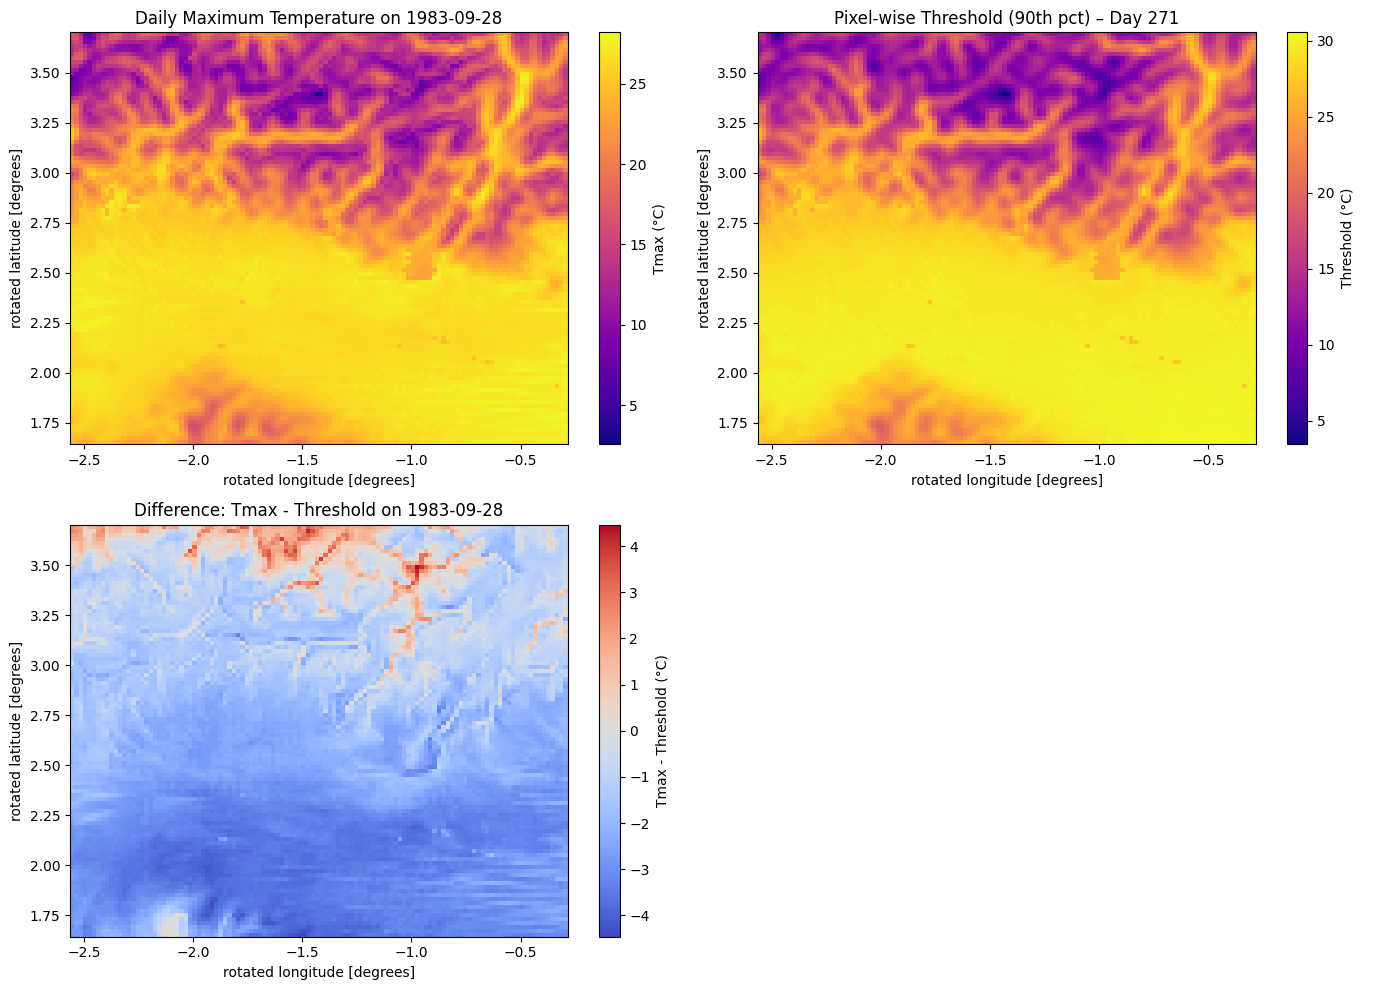


Tmax Statistics:
 - Min: 2.58°C
 - Max: 28.18°C
 - Mean: 21.85°C

Threshold Statistics:
 - Min: 3.44°C
 - Max: 30.55°C
 - Mean: 23.74°C

Difference (Tmax - Threshold) Statistics:
 - Min: -4.46°C
 - Max: 4.46°C
 - Mean: -1.90°C


In [8]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# === PATH DEI DATASET ===
tmax_path = r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Pixelwise_thresholds_extraction_&_max_daily_temp\extraction_thorugh_T_2M_dataset\tmax_daily_cube_T_2M.nc"
threshold_path = r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Pixelwise_thresholds_extraction_&_max_daily_temp\extraction_thorugh_T_2M_dataset\thresholds_15day_90p_T_2M.nc"

# === CARICAMENTO ===
ds_tmax = xr.open_dataset(tmax_path)
ds_thresholds = xr.open_dataset(threshold_path)

# === RANGE TEMPORALE ===
print("\nTmax range:", pd.to_datetime(str(ds_tmax.time.values[0])), "→", pd.to_datetime(str(ds_tmax.time.values[-1])))
print("Threshold shape:", ds_thresholds.TMAX_threshold_15d.shape, "(should be lat x lon x 366)")

# === SELEZIONE GIORNO PER IL PLOT ===
sample_day = ds_tmax.time.values[1000]  # Cambia indice per selezionare un altro giorno
doy = pd.to_datetime(sample_day).dayofyear

# === ESTRAZIONE DATI E CONVERSIONE IN °C ===
tmax_sample = ds_tmax.TMAX_daily.sel(time=sample_day) - 273.15
threshold_sample = ds_thresholds.TMAX_threshold_15d.isel(dayofyear=doy - 1) - 273.15
difference = tmax_sample - threshold_sample

# === PLOT ===
fig, axs = plt.subplots(2, 2, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 1]})

# Tmax
tmax_sample.plot(ax=axs[0, 0], cmap="plasma", cbar_kwargs={'label': 'Tmax (°C)'})
axs[0, 0].set_title(f"Daily Maximum Temperature on {pd.to_datetime(sample_day).strftime('%Y-%m-%d')}")

# Threshold
threshold_sample.plot(ax=axs[0, 1], cmap="plasma", cbar_kwargs={'label': 'Threshold (°C)'})
axs[0, 1].set_title(f"Pixel-wise Threshold (90th pct) – Day {doy}")

# Difference
difference.plot(ax=axs[1, 0], cmap="coolwarm", center=0, cbar_kwargs={'label': 'Tmax - Threshold (°C)'})
axs[1, 0].set_title(f"Difference: Tmax - Threshold on {pd.to_datetime(sample_day).strftime('%Y-%m-%d')}")
axs[1, 1].axis("off")

plt.tight_layout()
plt.show()

# === STATISTICHE BASE ===
print("\nTmax Statistics:")
print(f" - Min: {float(tmax_sample.min()):.2f}°C")
print(f" - Max: {float(tmax_sample.max()):.2f}°C")
print(f" - Mean: {float(tmax_sample.mean()):.2f}°C")

print("\nThreshold Statistics:")
print(f" - Min: {float(threshold_sample.min()):.2f}°C")
print(f" - Max: {float(threshold_sample.max()):.2f}°C")
print(f" - Mean: {float(threshold_sample.mean()):.2f}°C")

print("\nDifference (Tmax - Threshold) Statistics:")
print(f" - Min: {float(difference.min()):.2f}°C")
print(f" - Max: {float(difference.max()):.2f}°C")
print(f" - Mean: {float(difference.mean()):.2f}°C")

#### 041.3 - Pixelwise threshold analysis

Rotated longitude selezionata: -1.45325 (indice: 55)


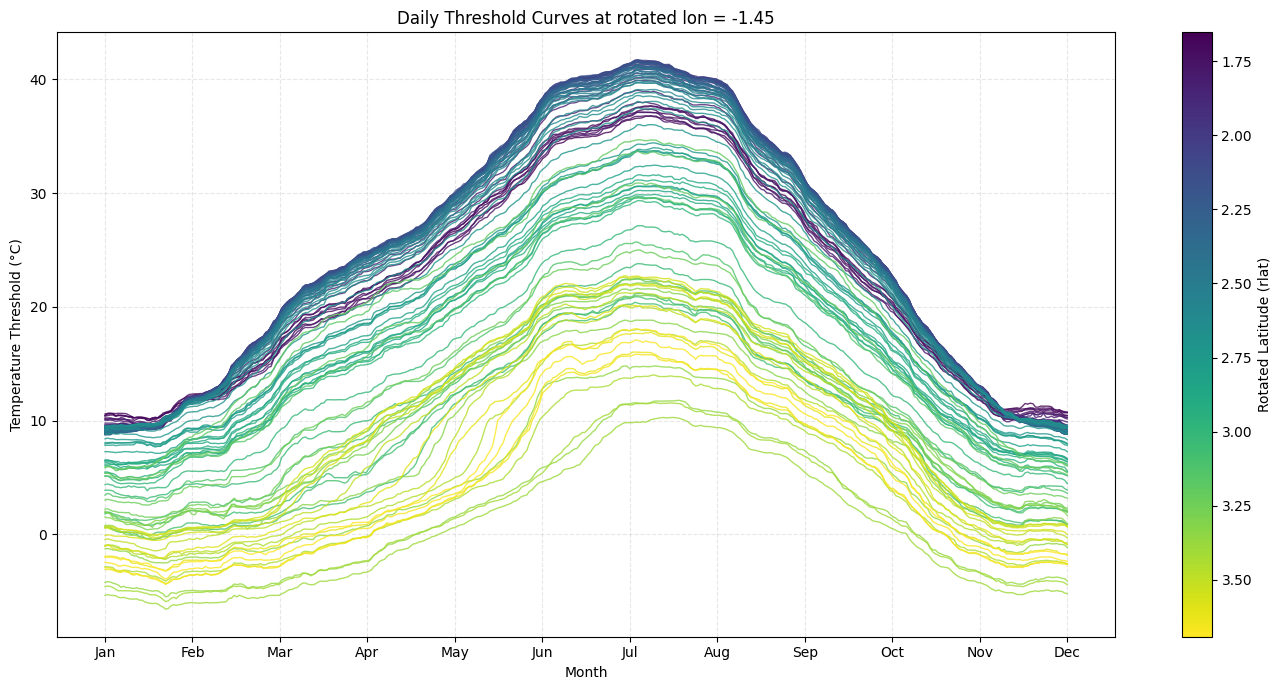

In [42]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# === CONFIG ===
data_path = r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Pixelwise_thresholds_extraction_&_max_daily_temp\thresholds_15day_90p.nc"
ds = xr.open_dataset(data_path)

# === SELEZIONE LONGITUDINE ROTATA ===
rlon_input = -1.45
rlon_values = ds['rlon'].values
lon_idx = np.abs(rlon_values - rlon_input).argmin()
print(f"Rotated longitude selezionata: {rlon_values[lon_idx]:.5f} (indice: {lon_idx})")

# === ESTRAI E CONVERTI I DATI ===
subset = ds['TMAX_threshold_15d'].isel(rlon=lon_idx)  # (rlat, dayofyear)
subset_celsius = subset - 273.15

rlats = ds['rlat'].values
doy = np.arange(1, 367)

# === FIGURA ===
fig, ax = plt.subplots(figsize=(14, 7))

# Colori secondo latitudine
norm = plt.Normalize(rlats.min(), rlats.max())
colors = plt.cm.viridis(norm(rlats))

# Plot
for i in range(len(rlats)):
    y = subset_celsius.isel(rlat=i).values
    ax.plot(doy, y, color=colors[i], alpha=0.8, lw=1)

# Etichette mese
month_ticks = np.linspace(1, 366, 12)
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax.set_xticks(month_ticks)
ax.set_xticklabels(month_labels)

ax.set_title(f"Daily Threshold Curves at rotated lon = {rlon_values[lon_idx]:.2f}")
ax.set_xlabel("Month")
ax.set_ylabel("Temperature Threshold (°C)")
ax.grid(True, linestyle="--", alpha=0.3)

# Colorbar invertita
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="Rotated Latitude (rlat)")
cbar.ax.invert_yaxis()  # Inversione colorbar

plt.tight_layout()
plt.show()

In [43]:
import xarray as xr
import numpy as np
import plotly.graph_objects as go

# === CONFIG ===
file_path = r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Pixelwise_thresholds_extraction_&_max_daily_temp\thresholds_15day_90p.nc"
rlon_input = -1.45  # Cambia se vuoi selezionare un'altra longitudine

# === LOAD DATASET ===
ds = xr.open_dataset(file_path)

# === TROVA INDICE LONGITUDINE ===
lon_idx = np.abs(ds['rlon'].values - rlon_input).argmin()
rlon_selected = ds['rlon'].values[lon_idx]
print(f"Selected rotated longitude: {rlon_selected:.2f} (index {lon_idx})")

# === ESTRAI E CONVERTI A CELSIUS ===
thresholds_k = ds['TMAX_threshold_15d'].isel(rlon=lon_idx)
thresholds_c = thresholds_k - 273.15
thresholds_c = thresholds_c.transpose("rlat", "dayofyear")  # Assicura l’ordine corretto

# === RIMUOVI NaN ===
thresholds_c_clean = thresholds_c.where(~np.isnan(thresholds_c), other=0)

# === COORDINATE ===
rlats = ds['rlat'].values
days = np.arange(1, 367)
X, Y = np.meshgrid(days, rlats)

# === PLOT ===
fig = go.Figure(data=[go.Surface(
    z=thresholds_c_clean.values,
    x=X,
    y=Y,
    colorscale='Viridis',
    colorbar=dict(title="Threshold (°C)")
)])

fig.update_layout(
    title=f"Daily Heatwave Thresholds (°C) at rotated lon = {rlon_selected:.2f}",
    scene=dict(
        xaxis_title='Day of Year',
        yaxis_title='Rotated Latitude',
        zaxis_title='Threshold (°C)'
    ),
    autosize=True,
    margin=dict(l=10, r=10, b=10, t=40)
)

fig.show()

Selected rotated longitude: -1.45 (index 55)


## Estrazione dataset di heatwaves

#### 041.4 - Generation of the data cube containing the residuals between each pixel temperature and its own threshold for each day of the whole dataset

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import os

# === PATH DATASET ===
tmax_path = r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Pixelwise_thresholds_extraction_&_max_daily_temp\tmax_daily_cube.nc"
thresholds_path = r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Pixelwise_thresholds_extraction_&_max_daily_temp\thresholds_15day_90p.nc"
output_path = r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Pixelwise_thresholds_extraction_&_max_daily_temp\residuals_daily_cube.nc"

# === RIMOZIONE FILE OUTPUT SE ESISTE ===
if os.path.exists(output_path):
    os.remove(output_path)
    print(f" File esistente rimosso: {output_path}")

# === CARICAMENTO DATASET ===
print(" Caricamento dataset Tmax...")
ds_tmax = xr.open_dataset(tmax_path)
print(" Caricamento dataset soglie...")
ds_thr = xr.open_dataset(thresholds_path)

# === VARIABILI ===
tmax = ds_tmax["TMAX_daily"]
thresholds = ds_thr["TMAX_threshold_15d"]

# === INFO ===
print(f"\nTmax shape: {tmax.shape} (time, rlat, rlon)")
print(f"Threshold shape: {thresholds.shape} (rlat, rlon, dayofyear)")

# === CALCOLO RESIDUI ===
print("\n Inizio calcolo residui...")
start_time = datetime.now()

# Estrai dayofyear per ogni giorno del dataset Tmax
dayofyears = pd.to_datetime(tmax["time"].values).dayofyear

# Crea array di soglie per ogni giorno
thresholds_matched = xr.concat(
    [thresholds.isel(dayofyear=doy - 1) for doy in dayofyears],
    dim="time"
)
thresholds_matched["time"] = tmax["time"]

# Calcolo residui
residuals = tmax - thresholds_matched
residuals.name = "TMAX_residual"
residuals.attrs["units"] = "°C"
residuals.attrs["description"] = "TMAX - soglia_15day_90p"

# === SALVA ===
print(f"\n Salvataggio su: {output_path}")
residuals.to_dataset().to_netcdf(output_path)

end_time = datetime.now()
elapsed = (end_time - start_time).total_seconds() / 60
print(f"\n Operazione completata in {elapsed:.1f} minuti.")

 File esistente rimosso: C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Pixelwise_thresholds_extraction_&_max_daily_temp\residuals_daily_cube.nc
 Caricamento dataset Tmax...
 Caricamento dataset soglie...

Tmax shape: (15705, 103, 114) (time, rlat, rlon)
Threshold shape: (366, 103, 114) (rlat, rlon, dayofyear)

 Inizio calcolo residui...

 Salvataggio su: C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Pixelwise_thresholds_extraction_&_max_daily_temp\residuals_daily_cube.nc

 Operazione completata in 1.7 minuti.


<xarray.Dataset>
Dimensions:        (time: 15705, rlon: 114, rlat: 103)
Coordinates:
  * time           (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2023-12-31
  * rlon           (rlon) float64 -2.553 -2.533 -2.513 ... -0.3132 -0.2932
    lon            (rlat, rlon) float32 ...
    lat            (rlat, rlon) float32 ...
  * rlat           (rlat) float64 1.652 1.672 1.692 1.712 ... 3.652 3.672 3.692
    height_2m      float32 ...
    dayofyear      (time) int32 ...
Data variables:
    TMAX_residual  (time, rlat, rlon) float32 ...


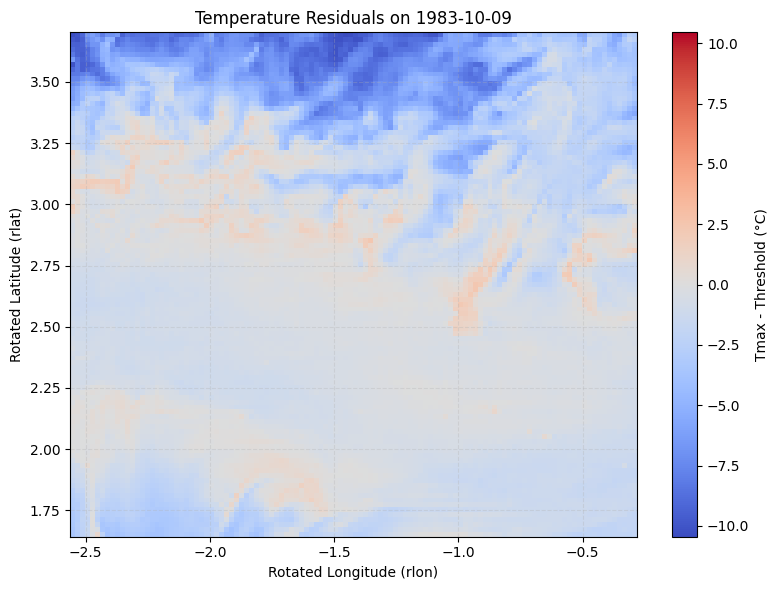

In [5]:
# === CONFIG ===
residuals_path = r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Pixelwise_thresholds_extraction_&_max_daily_temp\residuals_daily_cube.nc"
var_name = "TMAX_residual"  # Nome della variabile nel file

# === CARICA DATASET ===
ds = xr.open_dataset(residuals_path)
print(ds)

# === SCEGLI GIORNO CASUALE ===
times = ds["time"].values
random_day = random.choice(times)

# === ESTRAI MAPPA DEL GIORNO ===
residual_day = ds[var_name].sel(time=random_day)

# === PLOT ===
plt.figure(figsize=(8, 6))
residual_day.plot(
    cmap="coolwarm",
    center=0,
    cbar_kwargs={'label': 'Tmax - Threshold (°C)'}
)
plt.title(f"Temperature Residuals on {pd.to_datetime(str(random_day)).strftime('%Y-%m-%d')}")
plt.xlabel("Rotated Longitude (rlon)")
plt.ylabel("Rotated Latitude (rlat)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

#### 041.5 - Heatwave duration and intensity extraction from the residual data cube

In [7]:
import xarray as xr
import numpy as np
import pandas as pd
import os

# === CONFIGURAZIONE ===
residuals_path = r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Pixelwise_thresholds_extraction_&_max_daily_temp\extraction_thorugh_TMAX_2M_dataset\residuals_daily_cube.nc"
anno_da_analizzare = 2023
soglia_percentuale = 0.60  # 60% dei pixel positivi
pixel_area_km2 = 2.2 * 2.2  # area di ciascun pixel (km²)
area_minima_km2 = 40000     # soglia minima di area coperta (km²)

# === CARICAMENTO DATASET ===
ds = xr.open_dataset(residuals_path)
residui = ds["TMAX_residual"]

# === SELEZIONE ANNO SPECIFICO ===
residui_anno = residui.sel(time=residui["time"].dt.year == anno_da_analizzare)

# === ANALISI GIORNO PER GIORNO ===
risultati = []

for t in residui_anno.time:
    giorno = pd.to_datetime(t.values)
    residuo_giornaliero = residui_anno.sel(time=t)

    valori = residuo_giornaliero.values
    valori_validi = ~np.isnan(valori)

    n_pixel_validi = valori_validi.sum()
    n_pixel_positivi = (valori > 0).sum()

    percentuale_positivi = n_pixel_positivi / n_pixel_validi

    # Calcolo area coperta da pixel positivi
    area_positiva = n_pixel_positivi * pixel_area_km2

    if (percentuale_positivi >= soglia_percentuale) and (area_positiva >= area_minima_km2):
        somma_positivi = valori[valori > 0].sum()
        media_positivi = valori[valori > 0].mean()
        somma_totale = np.nansum(valori)  # include sia positivi che negativi

        risultati.append({
            "date": giorno,
            "sum_positive_excess": float(somma_positivi),
            "avg_positive_excess": float(media_positivi),
            "sum_all_excess": float(somma_totale),
            "area_positive_km2": float(area_positiva)
        })

# === CONVERSIONE IN DATAFRAME ===
df = pd.DataFrame(risultati)

# === CALCOLO DURATA DEI PERIODI CONSECUTIVI ===
if not df.empty:
    df["gap"] = (df["date"] - df["date"].shift()).dt.days.ne(1).cumsum()
    df["duration"] = df.groupby("gap")["date"].transform("count")
    df = df.drop(columns="gap")

# === RISULTATO ===
print(df.head(30))

         date  sum_positive_excess  avg_positive_excess  sum_all_excess  \
0  2023-01-05         25875.123047             2.490387    25094.187500   
1  2023-02-15         15800.397461             1.852333    14468.752930   
2  2023-03-22         10389.794922             1.021311     9675.186523   
3  2023-03-23          9337.940430             0.898570     8170.616211   
4  2023-07-10         15658.744141             1.601918    13335.900391   
5  2023-07-11         19091.904297             1.744509    18692.453125   
6  2023-07-17         19051.574219             1.726781    18342.992188   
7  2023-07-18         23713.011719             2.094789    23558.687500   
8  2023-07-19         25718.193359             2.470528    24568.048828   
9  2023-08-15          6486.398438             0.756343     5267.493652   
10 2023-08-19         17484.341797             1.542645    17330.248047   
11 2023-08-20         21181.949219             1.957847    20515.566406   
12 2023-08-21         341

## Estrazione dataset di heatwaves sull'intero intervallo temporale 1981-2023 

## DA RI RUNNARE

In [52]:
import xarray as xr
import pandas as pd
import numpy as np
import time

# ===============================
# PARAMETRI
# ===============================
START_YEAR = 1981
END_YEAR   = 2023 
THRESHOLD_CHOICE = "31"  # "15" o "31"
CSV_THRESHOLDS = "thresholds_15_31.csv"  # CSV con day_of_year, threshold_15, threshold_31 in Kelvin

# ===============================
# FUNZIONI DI SUPPORTO
# ===============================
def is_leap_year(year: int) -> bool:
    return (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0))

def get_heatwave_blocks(is_hw_bool: pd.Series) -> list:
    """
    Dato un array booleano is_hw_bool (True = giorno di heat wave, False = nella norma),
    restituisce la colonna "heat_wave" con la lunghezza TOTALE del blocco consecutivo.
    Ritorna una lista di stringhe (es. "3 giorno", "nella norma").
    """
    n = len(is_hw_bool)
    heat_wave_result = [None]*n
    i = 0
    while i < n:
        if is_hw_bool.iloc[i]:
            start = i
            while i < n and is_hw_bool.iloc[i]:
                i += 1
            run_length = i - start
            label = f"{run_length} giorno"
            for j in range(start, i):
                heat_wave_result[j] = label
        else:
            heat_wave_result[i] = "nella norma"
            i += 1
    return heat_wave_result

# ===============================
# CARICAMENTO UNA TANTUM
# ===============================
# Carica il dataset NetCDF (in Kelvin) una volta sola
ds_all = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-81_23.nc")
ds_all = ds_all.chunk({"time": 365, "rlat": 50, "rlon": 50})

# Carica il CSV delle soglie (in Kelvin)
df_thresholds = pd.read_csv(CSV_THRESHOLDS)
df_thresholds.set_index("day_of_year", inplace=True)

# Creiamo un elenco per accumulare i DataFrame annuali
df_list_all_years = []

for year in range(START_YEAR, END_YEAR + 1):
    t0 = time.time()
    year_str = str(year)
    
    # ---------------------------
    # 1) Filtra il dataset per l'anno
    # ---------------------------
    ds_year = ds_all.sel(time=slice(f"{year_str}-01-01", f"{year_str}-12-31"))
    ds_year = ds_year.chunk({"time": -1})  # Minimizza i chunk su "time"
    
    # ---------------------------
    # 2) Assegna la coordinata "time_floor" arrotondata al giorno
    # ---------------------------
    ds_year = ds_year.assign_coords(time_floor=ds_year.time.dt.floor("D"))
    
    # ---------------------------
    # 3) Calcola le statistiche giornaliere (Mean, Median, P90, P95, Max) usando groupby su "time_floor"
    #    e converti in DataFrame
    # ---------------------------
    var_single = ds_year["TMAX_2M"].chunk({"rlat": -1, "rlon": -1})
    
    ds_daily_mean   = var_single.groupby("time_floor").mean(dim=["rlat", "rlon"]).compute()
    ds_daily_median = var_single.groupby("time_floor").quantile(0.5,  dim=["rlat", "rlon"]).compute()
    ds_daily_p90    = var_single.groupby("time_floor").quantile(0.90, dim=["rlat", "rlon"]).compute()
    ds_daily_p95    = var_single.groupby("time_floor").quantile(0.95, dim=["rlat", "rlon"]).compute()
    ds_daily_max    = var_single.groupby("time_floor").max(dim=["rlat", "rlon"]).compute()
    
    df_mean   = ds_daily_mean.to_dataframe(name="Mean").reset_index()[["time_floor", "Mean"]].rename(columns={"time_floor": "Date"})
    df_median = ds_daily_median.to_dataframe(name="Median").reset_index()[["time_floor", "Median"]].rename(columns={"time_floor": "Date"})
    df_p90    = ds_daily_p90.to_dataframe(name="P90").reset_index()[["time_floor", "P90"]].rename(columns={"time_floor": "Date"})
    df_p95    = ds_daily_p95.to_dataframe(name="P95").reset_index()[["time_floor", "P95"]].rename(columns={"time_floor": "Date"})
    df_max    = ds_daily_max.to_dataframe(name="Max").reset_index()[["time_floor", "Max"]].rename(columns={"time_floor": "Date"})
    
    # Unisci le statistiche
    df_stats = (
        df_mean
        .merge(df_median, on="Date", how="left")
        .merge(df_p90,    on="Date", how="left")
        .merge(df_p95,    on="Date", how="left")
        .merge(df_max,    on="Date", how="left")
    )
    df_stats.drop_duplicates(subset=["Date"], inplace=True)
    
    # ---------------------------
    # 4) day_of_year e day_of_year_noleap + Merge con CSV soglie
    # ---------------------------
    df_stats["Date"] = pd.to_datetime(df_stats["Date"])
    df_stats["day_of_year"] = df_stats["Date"].dt.dayofyear
    df_stats["day_of_year_noleap"] = df_stats["day_of_year"]
    # Gestisci anni bisestili
    leap_mask = (df_stats["Date"].dt.is_leap_year) & (df_stats["day_of_year"] > 60)
    df_stats.loc[leap_mask, "day_of_year_noleap"] = df_stats.loc[leap_mask, "day_of_year"] - 1
    
    # Merge con df_thresholds
    df_stats_merged = pd.merge(
        df_stats,
        df_thresholds.reset_index(),  # "day_of_year" come colonna
        left_on="day_of_year_noleap",
        right_on="day_of_year",
        how="left"
    )
    
    # ---------------------------
    # 5) Converti in Celsius
    # ---------------------------
    stat_cols = ["Mean", "Median", "P90", "P95", "Max"]
    for col in stat_cols:
        df_stats_merged[col] = df_stats_merged[col] - 273.15  # dataset originale in Kelvin
    
    # Converti la soglia selezionata
    thr_col = f"threshold_{THRESHOLD_CHOICE}"
    if thr_col in df_stats_merged.columns:
        df_stats_merged[thr_col] = df_stats_merged[thr_col] - 273.15
    
    # ---------------------------
    # 6) Confronto e definizione colonna "heat_wave"
    # ---------------------------
    # Creiamo i confronti "Mean>threshold_xxx", etc.
    col_mean   = f"Mean>{thr_col}"
    col_median = f"Median>{thr_col}"
    col_p90    = f"P90>{thr_col}"
    col_p95    = f"P95>{thr_col}"
    col_max    = f"Max>{thr_col}"
    
    df_stats_merged[col_mean]   = np.where(df_stats_merged["Mean"]   > df_stats_merged[thr_col], "Yes", "No")
    df_stats_merged[col_median] = np.where(df_stats_merged["Median"] > df_stats_merged[thr_col], "Yes", "No")
    df_stats_merged[col_p90]    = np.where(df_stats_merged["P90"]    > df_stats_merged[thr_col], "Yes", "No")
    df_stats_merged[col_p95]    = np.where(df_stats_merged["P95"]    > df_stats_merged[thr_col], "Yes", "No")
    df_stats_merged[col_max]    = np.where(df_stats_merged["Max"]    > df_stats_merged[thr_col], "Yes", "No")
    
    # Ordina per Date
    df_stats_merged.sort_values("Date", inplace=True)
    df_stats_merged.reset_index(drop=True, inplace=True)
    
    # Creiamo un array booleano: True se almeno una colonna di confronto è "Yes"
    comp_cols = [col_mean, col_median, col_p90, col_p95, col_max]
    is_hw_bool = df_stats_merged.apply(lambda row: any(row[c] == "Yes" for c in comp_cols), axis=1)
    
    # Costruiamo la colonna "heat_wave" come blocchi consecutivi
    heat_wave_result = []
    i_idx = 0
    n_idx = len(df_stats_merged)
    while i_idx < n_idx:
        if is_hw_bool.iloc[i_idx]:
            start_i = i_idx
            while i_idx < n_idx and is_hw_bool.iloc[i_idx]:
                i_idx += 1
            run_len = i_idx - start_i
            label = f"{run_len} giorno"
            for j in range(start_i, i_idx):
                heat_wave_result.append(label)
        else:
            heat_wave_result.append("nella norma")
            i_idx += 1
    
    # Se la lunghezza non corrisponde, potremmo aver generato mismatch. 
    # Invece, costruiamo la lista via indexing:
    heat_wave_result_list = [None]*n_idx
    i_idx = 0
    while i_idx < n_idx:
        if is_hw_bool.iloc[i_idx]:
            start_i = i_idx
            while i_idx < n_idx and is_hw_bool.iloc[i_idx]:
                i_idx += 1
            run_len = i_idx - start_i
            label = f"{run_len} giorno"
            for j in range(start_i, i_idx):
                heat_wave_result_list[j] = label
        else:
            heat_wave_result_list[i_idx] = "nella norma"
            i_idx += 1
    
    df_stats_merged["heat_wave"] = heat_wave_result_list
    
    # Aggiungi una colonna "year"
    df_stats_merged["year"] = year
    
    # Salva in una lista
    df_list_all_years.append(df_stats_merged)
    
    # Tempo di esecuzione
    print(f"Anno {year} completato. Righe finali: {len(df_stats_merged)}")

# Concatenazione di tutti gli anni
df_final = pd.concat(df_list_all_years, ignore_index=True)
df_final.to_csv(f"heatwave_events_{START_YEAR}_{END_YEAR}_window{THRESHOLD_CHOICE}.csv", index=False)
print("Elaborazione completata, file CSV creato con successo!")

Anno 1981 completato. Righe finali: 365


KeyboardInterrupt: 

#### 04.0 Estrazione dell'intensity per ciascuna heat wave, durata, inizio e fine

In [23]:
import pandas as pd
import numpy as np
import time

# ---------------------------
# PARAMETRI
# ---------------------------
START_YEAR = 1980         # Primo anno del periodo storico
END_YEAR   = 2023         # Ultimo anno del periodo
THRESHOLD_CHOICE = "31"   # "15" o "31"
INPUT_CSV = "heatwave_events_1981_2023_window31.csv"  # CSV contenente i dati in Celsius

# ---------------------------
# FUNZIONI DI SUPPORTO
# ---------------------------
def get_all_events_from_df(df: pd.DataFrame) -> list:
    """
    Identifica TUTTI i blocchi consecutivi di giorni con heat_wave ≠ "nella norma"
    Restituisce una lista di eventi, ognuno rappresentato come lista di date consecutive
    """
    hw_df = df.loc[df["heat_wave"] != "nella norma"].copy()
    hw_df.sort_values("Date", inplace=True)
    hw_df.reset_index(drop=True, inplace=True)
    
    events = []
    current_event = []
    prev_date = None
    for _, row in hw_df.iterrows():
        current_date = row["Date"]
        if not current_event:
            current_event = [current_date]
        else:
            if (current_date - prev_date).days == 1:
                current_event.append(current_date)
            else:
                events.append(current_event)
                current_event = [current_date]
        prev_date = current_date
    if current_event:
        events.append(current_event)
    return events

# ---------------------------
# CODICE PRINCIPALE
# ---------------------------
df_all = pd.read_csv(INPUT_CSV, parse_dates=["Date"])

chosen_thr_col = f"threshold_{THRESHOLD_CHOICE}"
if chosen_thr_col not in df_all.columns:
    raise ValueError(f"Colonna {chosen_thr_col} non trovata nel CSV: {df_all.columns}")

final_events_list = []

for year in range(START_YEAR, END_YEAR + 1):
    t0 = time.time()
    
    df_year = df_all[df_all["Date"].dt.year == year].copy()
    df_year.sort_values("Date", inplace=True)
    df_year.reset_index(drop=True, inplace=True)
    
    events_year = get_all_events_from_df(df_year)
    
    short_events = 0  # Conta quanti eventi durano 1 o 2 giorni
    event_results = []
    
    for block in events_year:
        start_date = block[0]
        end_date = block[-1]
        duration = len(block)
        
        if duration <= 2:
            short_events += 1
        
        ev_df = df_year[df_year["Date"].isin(block)].copy()
        ev_df.sort_values("Date", inplace=True)
        diff = ev_df["Max"] - ev_df[chosen_thr_col]
        diff_clip = diff.clip(lower=0)
        heatwave_cumulative_intensity = diff_clip.sum()
        
        event_results.append({
            "start_date": start_date,
            "end_date": end_date,
            "duration": duration,
            "heatwave_cumulative_intensity": heatwave_cumulative_intensity,
            "year": year
        })
    
    df_events_year = pd.DataFrame(event_results)
    final_events_list.append(df_events_year)
    
    t1 = time.time()
    print(f"Anno {year} elaborato in {t1 - t0:.2f} secondi, heatwaves trovate: {len(df_events_year)}, eventi caldi <=2 giorni: {short_events}")

# Output finale
df_final_events = pd.concat(final_events_list, ignore_index=True)

output_filename = f"heatwave_intensity_index_{START_YEAR}_{END_YEAR}_window{THRESHOLD_CHOICE}.csv"
df_final_events.to_csv(output_filename, index=False)
print(f"File '{output_filename}' creato con successo!")

# Mostra anteprima
print(df_final_events.head(10))

Anno 1980 elaborato in 0.02 secondi, heatwaves trovate: 0, eventi caldi <=2 giorni: 0
Anno 1981 elaborato in 0.13 secondi, heatwaves trovate: 30, eventi caldi <=2 giorni: 16
Anno 1982 elaborato in 0.09 secondi, heatwaves trovate: 34, eventi caldi <=2 giorni: 21
Anno 1983 elaborato in 0.09 secondi, heatwaves trovate: 29, eventi caldi <=2 giorni: 16
Anno 1984 elaborato in 0.07 secondi, heatwaves trovate: 21, eventi caldi <=2 giorni: 14
Anno 1985 elaborato in 0.09 secondi, heatwaves trovate: 24, eventi caldi <=2 giorni: 16
Anno 1986 elaborato in 0.12 secondi, heatwaves trovate: 35, eventi caldi <=2 giorni: 25
Anno 1987 elaborato in 0.10 secondi, heatwaves trovate: 37, eventi caldi <=2 giorni: 24
Anno 1988 elaborato in 0.09 secondi, heatwaves trovate: 25, eventi caldi <=2 giorni: 12
Anno 1989 elaborato in 0.08 secondi, heatwaves trovate: 26, eventi caldi <=2 giorni: 14
Anno 1990 elaborato in 0.08 secondi, heatwaves trovate: 27, eventi caldi <=2 giorni: 14
Anno 1991 elaborato in 0.09 second

#### 04.0 Plot of heatwaves in the whole period by duration

#### Definition: 
Heatwave frequency is defined as the sum of all heatwave days, heatwave intensity as the average intensity across all heatwave days, and duration as the longest event. Perkins at al 2020

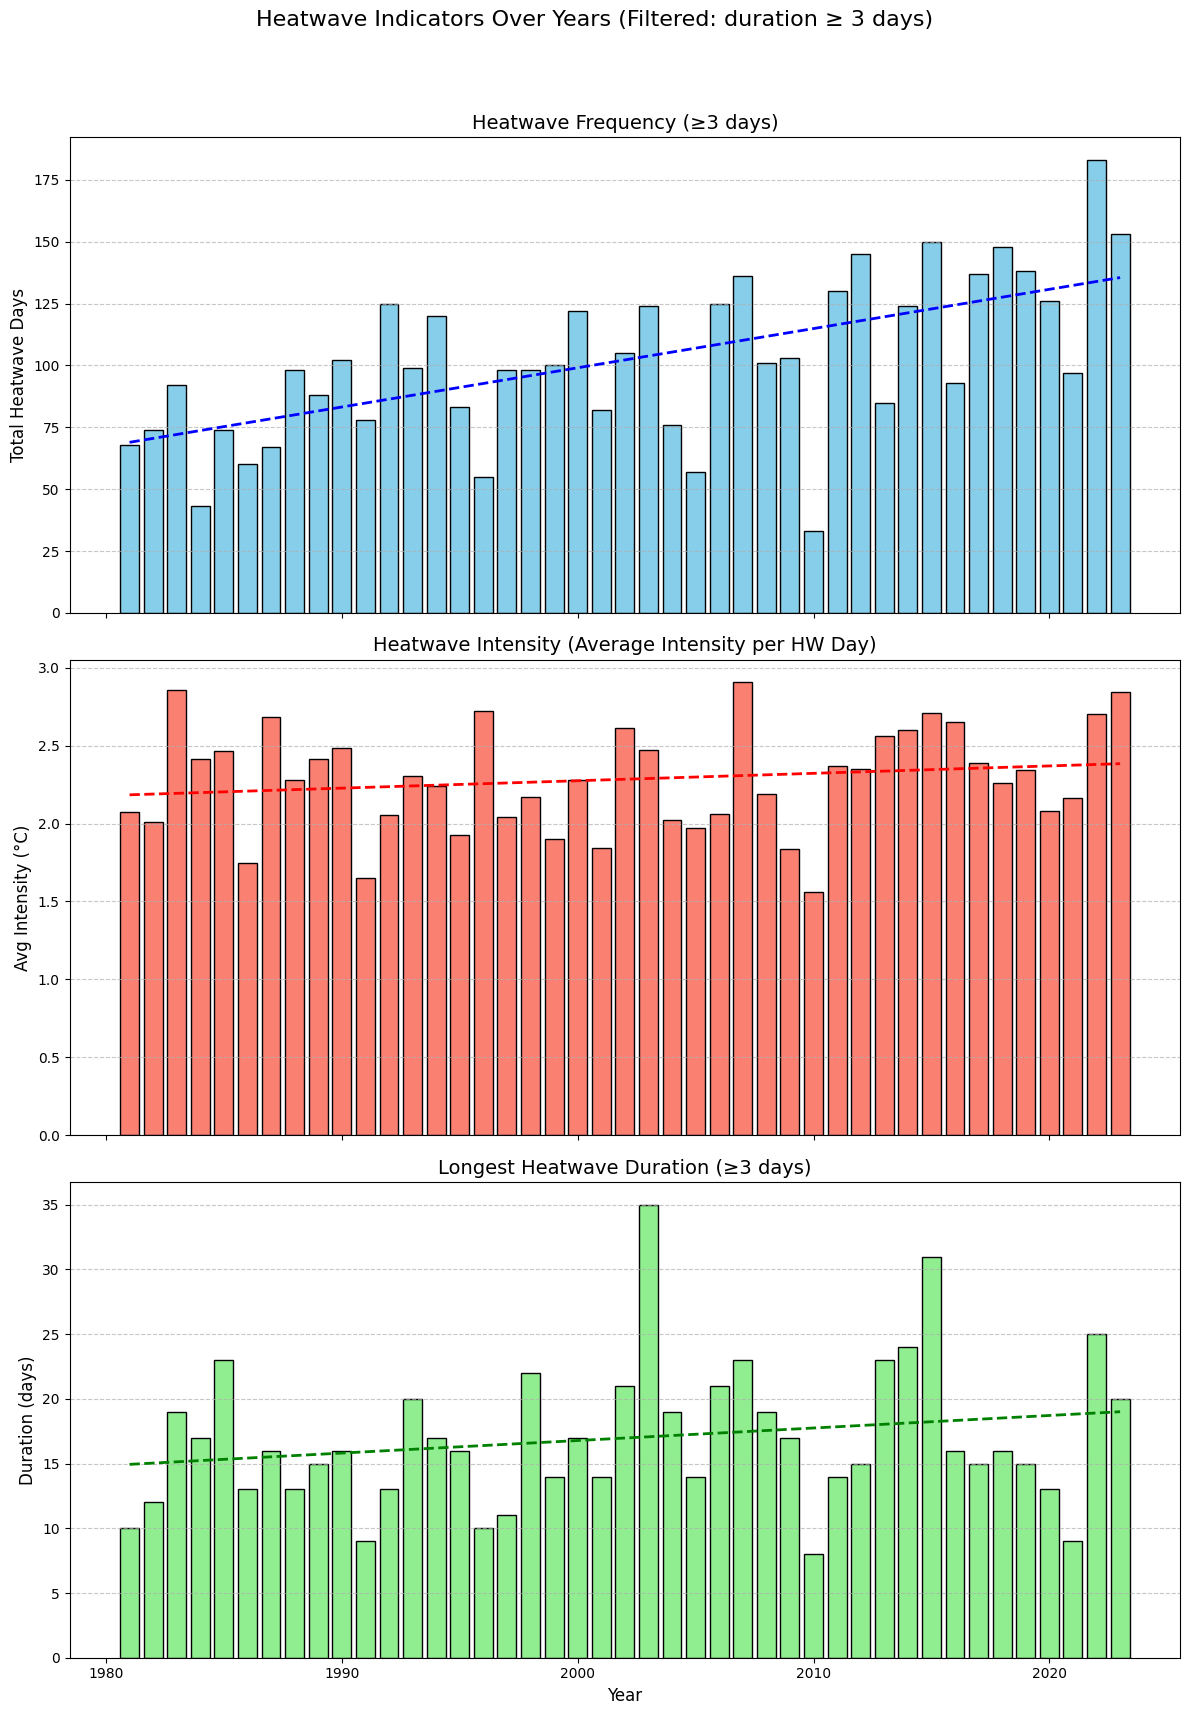

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# ---------------------------
# PARAMETRI
# ---------------------------
CSV_EVENTS = "heatwave_intensity_index_1980_2023_window31.csv"
START_YEAR = 1981
END_YEAR = 2023

# ---------------------------
# CARICAMENTO E FILTRO DATI
# ---------------------------
df = pd.read_csv(CSV_EVENTS, parse_dates=["start_date", "end_date"])

# Filtro: solo eventi con durata >= 3 giorni
df = df[df["duration"] >= 3]

# ---------------------------
# RAGGRUPPAMENTO PER ANNO
# ---------------------------
grouped = df.groupby("year").agg(
    total_heatwave_days=("duration", "sum"),
    total_intensity=("heatwave_cumulative_intensity", "sum"),
    max_duration=("duration", "max")
).reset_index()

grouped["avg_intensity"] = grouped["total_intensity"] / grouped["total_heatwave_days"]

# ---------------------------
# FUNZIONE TREND LINE
# ---------------------------
def plot_trend_line(ax, x, y, color='black'):
    coeffs = np.polyfit(x, y, 1)
    poly = np.poly1d(coeffs)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = poly(x_line)
    ax.plot(x_line, y_line, color=color, linestyle="--", linewidth=2)

# ---------------------------
# PLOT
# ---------------------------
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# 1. Frequenza (giorni totali di heatwave per anno)
axs[0].bar(grouped["year"], grouped["total_heatwave_days"], color="skyblue", edgecolor="black")
plot_trend_line(axs[0], grouped["year"], grouped["total_heatwave_days"], color="blue")
axs[0].set_title("Heatwave Frequency (≥3 days)", fontsize=14)
axs[0].set_ylabel("Total Heatwave Days", fontsize=12)
axs[0].grid(axis="y", linestyle="--", alpha=0.7)

# 2. Intensità media per giorno di heatwave
axs[1].bar(grouped["year"], grouped["avg_intensity"], color="salmon", edgecolor="black")
plot_trend_line(axs[1], grouped["year"], grouped["avg_intensity"], color="red")
axs[1].set_title("Heatwave Intensity (Average Intensity per HW Day)", fontsize=14)
axs[1].set_ylabel("Avg Intensity (°C)", fontsize=12)
axs[1].grid(axis="y", linestyle="--", alpha=0.7)

# 3. Durata massima per anno
axs[2].bar(grouped["year"], grouped["max_duration"], color="lightgreen", edgecolor="black")
plot_trend_line(axs[2], grouped["year"], grouped["max_duration"], color="green")
axs[2].set_title("Longest Heatwave Duration (≥3 days)", fontsize=14)
axs[2].set_ylabel("Duration (days)", fontsize=12)
axs[2].set_xlabel("Year", fontsize=12)
axs[2].grid(axis="y", linestyle="--", alpha=0.7)

plt.suptitle("Heatwave Indicators Over Years (Filtered: duration ≥ 3 days)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### 04.0 Heat waves magnifute classification

#### Classification Rousi et al 2022 
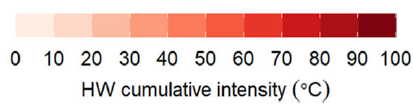

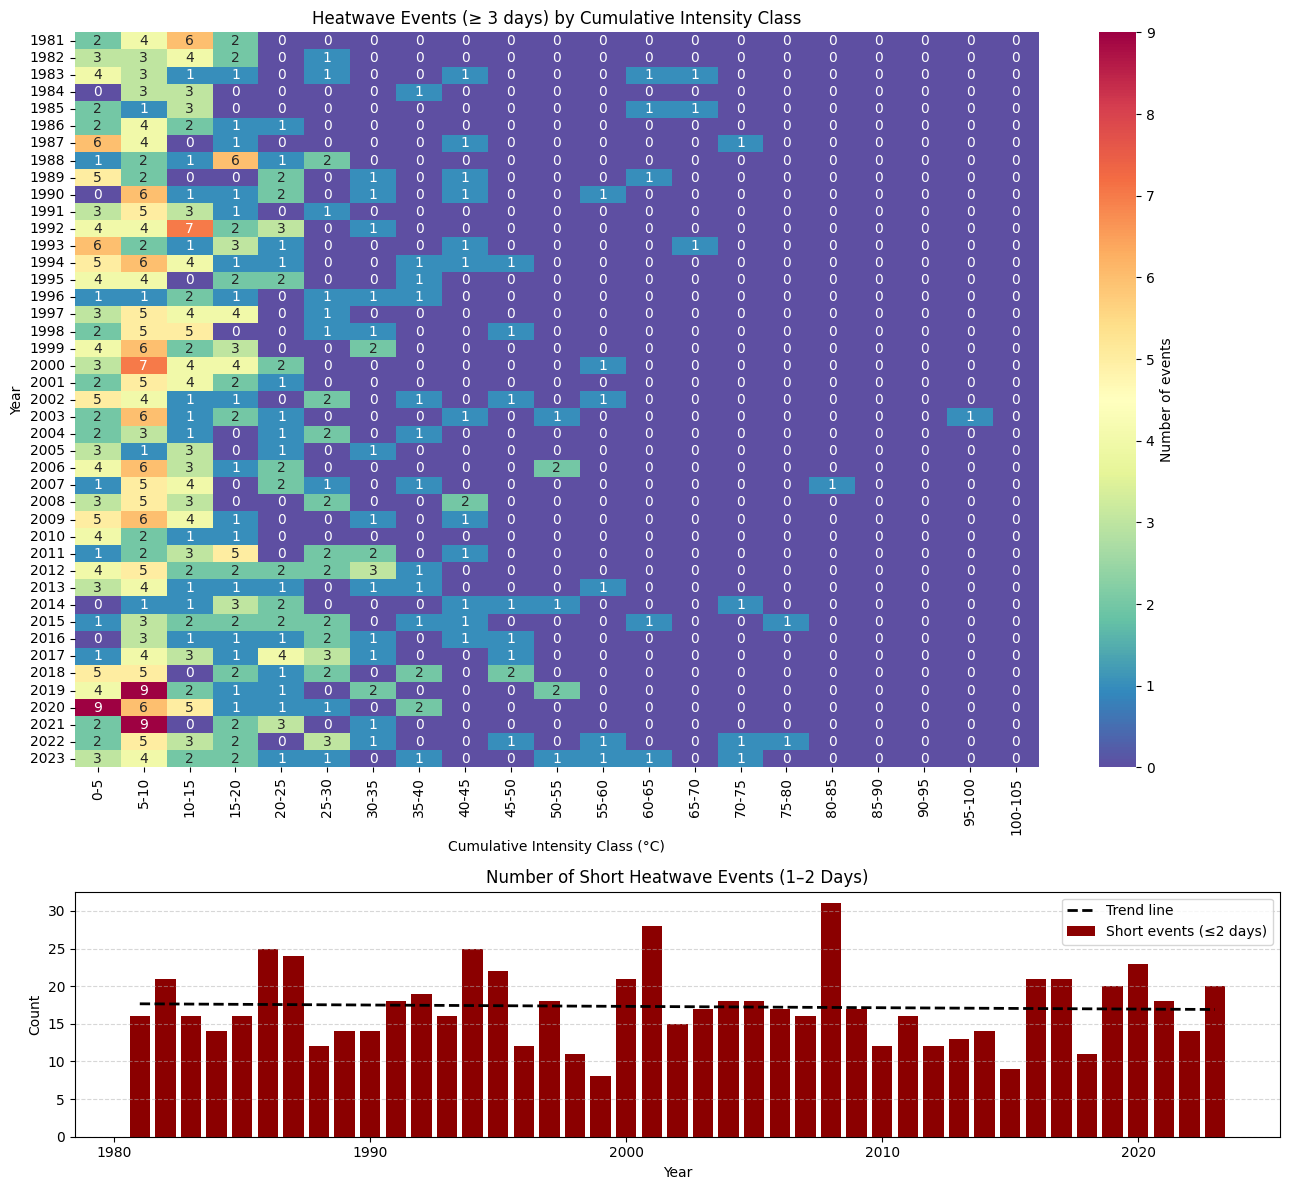

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ========== PARAMETRI ==========
csv_path = "heatwave_intensity_index_1980_2023_window31.csv"
colonna_intensità = "heatwave_cumulative_intensity"
pace = 5
bins = list(range(0, 110, pace))  # Classi: 0-5, 5-10, ..., 105-110
colormap = "Spectral_r"

# ========== CARICAMENTO ==========
df = pd.read_csv(csv_path, parse_dates=["start_date", "end_date"])
df["anno"] = df["start_date"].dt.year

# ========== SEPARAZIONE EVENTI ==========
df_short = df[df["duration"] <= 2].copy()
df_long = df[df["duration"] >= 3].copy()  # Eventi di 3 o più giorni

# ========== CATEGORIZZAZIONE ==========
labels = [f"{i}-{i+pace}" for i in bins[:-1]]
df_long["classe_intensità"] = pd.cut(df_long[colonna_intensità], bins=bins, right=False, labels=labels)

# ========== MATRICE PER EVENTI LUNGHI ==========
pivot_long = df_long.pivot_table(
    index="anno",
    columns="classe_intensità",
    values=colonna_intensità,
    aggfunc="count",
    fill_value=0
)

# ========== CONTEGGIO EVENTI BREVI ==========
all_years = sorted(df["anno"].unique())
serie_short = df_short["anno"].value_counts().reindex(all_years, fill_value=0)

# ========== PLOT ==========
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 12), gridspec_kw={"height_ratios": [3, 1]})

# ---- HEATMAP ----
sns.heatmap(pivot_long, annot=True, fmt="d", cmap=colormap,
            linewidths=0.0, linecolor='gray', cbar_kws={"label": "Number of events"}, ax=ax1)

ax1.set_title("Heatwave Events (≥ 3 days) by Cumulative Intensity Class")
ax1.set_xlabel("Cumulative Intensity Class (°C)")
ax1.set_ylabel("Year")

# ---- BARPLOT PER EVENTI ≤ 2 GIORNI ----
ax2.bar(serie_short.index, serie_short.values, color="darkred", label="Short events (≤2 days)")

# Trend line
x_vals = np.array(serie_short.index)
y_vals = serie_short.values
coeffs = np.polyfit(x_vals, y_vals, 1)
trendline = np.poly1d(coeffs)
ax2.plot(x_vals, trendline(x_vals), color="black", linestyle="--", linewidth=2, label="Trend line")

ax2.set_title("Number of Short Heatwave Events (1–2 Days)")
ax2.set_xlabel("Year")
ax2.set_ylabel("Count")
ax2.legend()
ax2.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

#### 04.7 - Plot di max temperatures of a given year vs thresholds
Method: Russo et al 2014

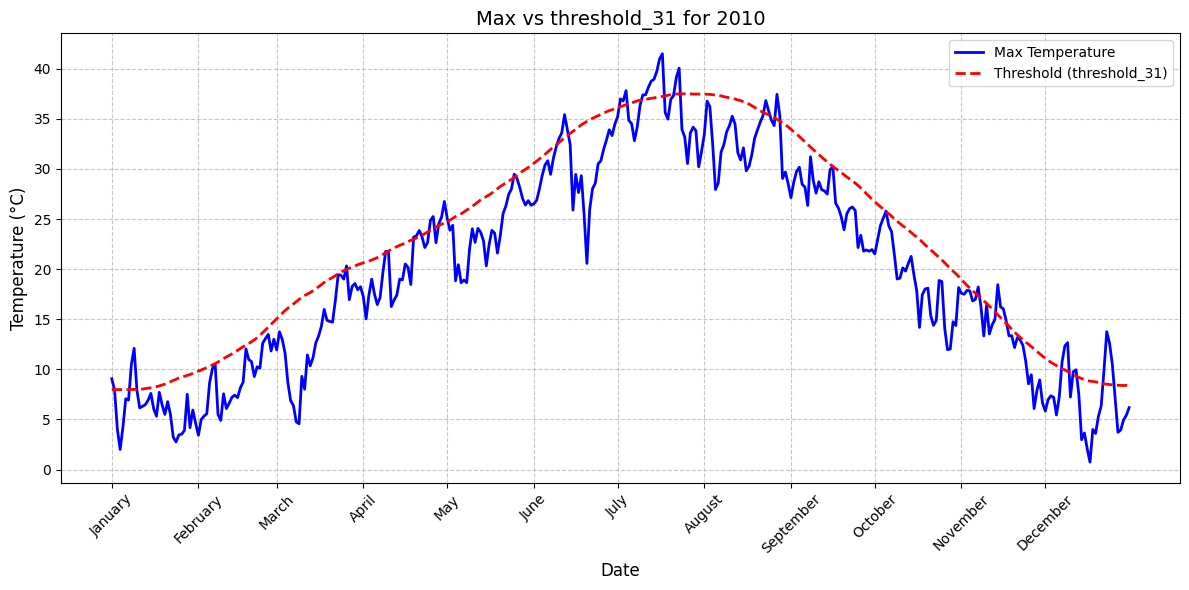

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# PARAMETRI DI INPUT
# ---------------------------
TARGET_YEAR = 2010            # Anno da plottare
THRESHOLD_CHOICE = "31"       # Scegli "15" o "31" per selezionare la soglia da usare
STATISTIC_CHOICE = "Max"      # Scegli la statistica da plottare: "Mean", "Median", "P90", "P95" o "Max"
CSV_FILE = "heatwave_events_1981_2023_window31.csv"  # CSV di input (con dati già in Celsius)

# ---------------------------
# CARICAMENTO E FILTRAGGIO DEI DATI
# ---------------------------
# Leggi il CSV e assicura che la colonna "Date" venga interpretata come datetime
df = pd.read_csv(CSV_FILE, parse_dates=["Date"])

# Filtra i dati per l'anno TARGET_YEAR
df_year = df[df["Date"].dt.year == TARGET_YEAR].copy()
df_year.sort_values("Date", inplace=True)
df_year.reset_index(drop=True, inplace=True)

# Definisci il nome della colonna della soglia in base al THRESHOLD_CHOICE
threshold_col = f"threshold_{THRESHOLD_CHOICE}"

# ---------------------------
# PLOT: STATISTICA VS SOGLIA
# ---------------------------
plt.figure(figsize=(12, 6))
plt.plot(df_year["Date"], df_year[STATISTIC_CHOICE], label=f"{STATISTIC_CHOICE} Temperature", 
         color="blue", linewidth=2)
plt.plot(df_year["Date"], df_year[threshold_col], label=f"Threshold ({threshold_col})", 
         color="red", linestyle="--", linewidth=2)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.title(f"{STATISTIC_CHOICE} vs {threshold_col} for {TARGET_YEAR}", fontsize=14)

# Imposta i tick dell'asse x con i nomi dei mesi
tick_dates = pd.date_range(start=f"{TARGET_YEAR}-01-01", end=f"{TARGET_YEAR}-12-31", freq="MS")
tick_labels = [d.strftime("%B") for d in tick_dates]
plt.xticks(tick_dates, tick_labels, rotation=45)

plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()